In [1]:
import json
import csv
import pandas as pd
import numpy as np
import scipy as sci
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import requests
import tensorflow as tf
from scipy import sparse
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#Open business.json file, create tsv file with business_id, business name, categories, and review count to be used as features 
#and stars as label

outfile = open("business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','categories', 'stars', 'review_count', 'postal code'])
with open('../yelp_dataset/yelp_academic_dataset_business.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'], row['categories'], row['stars'], row['review_count'], row['postal_code']])

outfile.close()

business_df= pd.read_csv('business.tsv', delimiter ="\t")

In [3]:
#Open review.json file, create tsv file with business_id,text to be used as features 
#and stars as label

outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('../yelp_dataset/yelp_academic_dataset_review.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()

review_df= pd.read_csv('review_stars.tsv', delimiter ="\t")

In [4]:
# Group all reviews by business_id
review_agg_df = review_df.groupby('business_id')['text'].sum()
review_df_ready_for_sklearn = pd.DataFrame({'business_id': review_agg_df.index, 'all_reviews': review_agg_df.values})

In [5]:
#Merge the resulting review aggregate dataframe with business dataframe
merge_df = pd.merge(business_df, review_df_ready_for_sklearn, on='business_id')



In [6]:
#Normalization of review count field so it becomes comparable and remove bias

from scipy.stats import zscore

merge_df.insert(3,'normalized_count',((merge_df['review_count'] - merge_df['review_count'].min()) / (merge_df['review_count'].max() - merge_df['review_count'].min())).astype(float))

merge_df['review_count'] = zscore(merge_df['review_count'])


In [7]:
# removing NaN categories

merge_df = merge_df[merge_df['categories'].notnull()]

merge_df = merge_df[0:10000]

In [8]:
# Extracting categories

from sklearn.preprocessing import MultiLabelBinarizer
encoded_categories = MultiLabelBinarizer()
category_matrix = encoded_categories.fit_transform(merge_df['categories'].str.split(','))

In [9]:
#TF-IDF calculation

tfidf = sk_text.TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,3))

In [10]:
# Fit the reviews column with TFIDFvectorizer
matrix = tfidf.fit_transform(merge_df['all_reviews'])
matrix = matrix.toarray()

In [11]:
# We are adding the normalized count to the original matrix with TFIDFvectorizer
x_matrix_minmax = np.column_stack((matrix, merge_df['normalized_count']))

# Zscore
x_matrix_zscore = np.column_stack((matrix, merge_df['review_count']))

In [12]:
#train test data for linear regression

x_train, x_test, y_train, y_test = train_test_split(x_matrix_minmax, merge_df['stars'] , test_size=0.2, random_state=42)

In [13]:
# linear regression

lin_reg_model = LinearRegression()

lin_reg_model.fit(x_train, y_train)

y_pred_linear = lin_reg_model.predict(x_test)

In [14]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test.index[i]
    print("business id - %s actual stars  - %f predicted - %f" 
          %(merge_df['business_id'][idx], y_test[idx], y_pred_linear[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars  - 4.000000 predicted - 3.630765
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars  - 4.000000 predicted - 3.837557
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars  - 4.000000 predicted - 4.120657
business id - jrhc4s5XMR8S8kpGdU08og actual stars  - 4.500000 predicted - 4.811266
business id - e7207sqC-pSn6GIf31ikhQ actual stars  - 4.000000 predicted - 3.747301
business id - CF9TxeEdP5QxihYFAl4sUg actual stars  - 4.000000 predicted - 4.036702
business id - zZPCAFK85NtitSNVP_wfYg actual stars  - 3.500000 predicted - 3.527224
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars  - 5.000000 predicted - 4.826022
business id - TTrYd662CZFRPaiwl-sUqA actual stars  - 2.000000 predicted - 1.793183
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars  - 2.500000 predicted - 2.515123


In [15]:
# RMS value

score_lin_classic = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print("Root Mean Squared Error: %.2f" % score_lin_classic)
print('Variance score: %.2f' % r2_score(y_test, y_pred_linear))

Root Mean Squared Error: 0.55
Variance score: 0.70


In [16]:
# label encoding data for logistic regression

label_encoder = preprocessing.LabelEncoder()

merge_df['encoded_stars'] = label_encoder.fit_transform(merge_df['stars'])

In [17]:
# train test data afor other models

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, merge_df['encoded_stars'] , test_size=0.2, random_state=42)

In [18]:
# logistic Regression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_train_lr, y_train_lr)

y_pred_logistic = Log_reg_model.predict(x_test_lr)


In [19]:
# RMs for logistic

score_log_classic = np.sqrt(mean_squared_error(y_test_lr, y_pred_logistic))
print("Root Mean Squared Error: %.2f" % score_log_classic)
print('Variance score: %.2f' % r2_score(y_test_lr, y_pred_logistic))

Root Mean Squared Error: 1.38
Variance score: 0.54


# Tensorflow Model for Regression

*** Training without early stopping and Model Checkpoint and RELU ***

In [20]:
#Tensor flow works well with 32 bit
y_stars_regression = merge_df['stars'].values.astype(np.float32)

In [21]:
#train test data
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_matrix_minmax, y_stars_regression , test_size=0.2)


In [22]:
# Tensorflow model for Regression with RELU

model_reg_relu = Sequential()

model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(1)) # Output

In [23]:
#Model training with Optimizer = adam

model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
model_reg_relu.fit(x_train_reg,y_train_reg,verbose=2,epochs=100) 


Epoch 1/100
 - 1s - loss: 1.9915
Epoch 2/100
 - 0s - loss: 0.3267
Epoch 3/100
 - 0s - loss: 0.2635
Epoch 4/100
 - 0s - loss: 0.2459
Epoch 5/100
 - 0s - loss: 0.2334
Epoch 6/100
 - 0s - loss: 0.2141
Epoch 7/100
 - 0s - loss: 0.1893
Epoch 8/100
 - 0s - loss: 0.1650
Epoch 9/100
 - 0s - loss: 0.1452
Epoch 10/100
 - 0s - loss: 0.1240
Epoch 11/100
 - 0s - loss: 0.1057
Epoch 12/100
 - 0s - loss: 0.0904
Epoch 13/100
 - 0s - loss: 0.0759
Epoch 14/100
 - 0s - loss: 0.0632
Epoch 15/100
 - 0s - loss: 0.0537
Epoch 16/100
 - 0s - loss: 0.0459
Epoch 17/100
 - 0s - loss: 0.0387
Epoch 18/100
 - 0s - loss: 0.0338
Epoch 19/100
 - 0s - loss: 0.0293
Epoch 20/100
 - 0s - loss: 0.0260
Epoch 21/100
 - 0s - loss: 0.0241
Epoch 22/100
 - 0s - loss: 0.0224
Epoch 23/100
 - 0s - loss: 0.0205
Epoch 24/100
 - 0s - loss: 0.0186
Epoch 25/100
 - 0s - loss: 0.0175
Epoch 26/100
 - 0s - loss: 0.0163
Epoch 27/100
 - 0s - loss: 0.0157
Epoch 28/100
 - 0s - loss: 0.0151
Epoch 29/100
 - 0s - loss: 0.0158
Epoch 30/100
 - 0s - lo

In [24]:
# Predict stars
pred_reg_simple = model_reg_relu.predict(x_test_reg)
print("Shape: {}".format(pred_reg_simple.shape))


Shape: (2000, 1)


In [25]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_simple[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.0, predicted Stars: [4.02945]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.5, predicted Stars: [4.2402587]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 4.5, predicted Stars: [4.6323643]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 3.0, predicted Stars: [3.6203978]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.0, predicted Stars: [1.7348386]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.5, predicted Stars: [4.168972]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 2.0, predicted Stars: [2.8198276]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [5.320364]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 3.0, predicted Stars: [3.9572725]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.0, predicted Stars: [4.4626665]


In [26]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_relu = np.sqrt(mean_squared_error(y_test_reg,pred_reg_simple))
print("Final score (RMSE): {}".format(score_reg_relu))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_simple))

Final score (RMSE): 0.587897777557373
R2 score: 0.66


# Training with early stopping and Model Checkpoint ReLU **

In [27]:
# setup early stopping monitor

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

In [28]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu.hdf5", verbose=2, save_best_only=True)

In [29]:
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 0.0046 - val_loss: 0.3496

Epoch 00001: val_loss improved from inf to 0.34958, saving model to ./best_weights_relu.hdf5
Epoch 2/100
 - 0s - loss: 0.0042 - val_loss: 0.3448

Epoch 00002: val_loss improved from 0.34958 to 0.34476, saving model to ./best_weights_relu.hdf5
Epoch 3/100
 - 0s - loss: 0.0039 - val_loss: 0.3496

Epoch 00003: val_loss did not improve from 0.34476
Epoch 4/100
 - 0s - loss: 0.0036 - val_loss: 0.3430

Epoch 00004: val_loss improved from 0.34476 to 0.34305, saving model to ./best_weights_relu.hdf5
Epoch 5/100
 - 0s - loss: 0.0039 - val_loss: 0.3485

Epoch 00005: val_loss did not improve from 0.34305
Epoch 6/100
 - 0s - loss: 0.0045 - val_loss: 0.3475

Epoch 00006: val_loss did not improve from 0.34305
Epoch 7/100
 - 0s - loss: 0.0045 - val_loss: 0.3474

Epoch 00007: val_loss did not improve from 0.34305
Epoch 00007: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 -

In [30]:
# Predict stars
pred_reg_stopping = model_reg_relu.predict(x_test_reg)
print("Shape: {}".format(pred_reg_stopping.shape))

Shape: (2000, 1)


In [31]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.0, predicted Stars: [4.074934]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.5, predicted Stars: [4.138316]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 4.5, predicted Stars: [4.816916]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 3.0, predicted Stars: [3.5320487]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.0, predicted Stars: [1.9106985]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.5, predicted Stars: [4.1183686]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 2.0, predicted Stars: [2.8297057]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [5.2395654]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 3.0, predicted Stars: [3.9169335]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.0, predicted Stars: [4.296971]


In [32]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_relu_stopping = np.sqrt(mean_squared_error(y_test_reg,pred_reg_stopping))
print("Final score (RMSE): {}".format(score_reg_relu_stopping))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_stopping))

Final score (RMSE): 0.5821277499198914
R2 score: 0.67


# Training without early stopping and Model Checkpoint and Sigmoid **

In [33]:
# Tensorflow model for Regression with sigmoid
model_reg_sig = Sequential()

model_reg_sig.add(Dense(25, input_dim=x_train_reg.shape[1], activation='sigmoid'))  
model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 2
model_reg_sig.add(Dense(1)) # Output


In [34]:
# Model training with sigmoid 
model_reg_sig.compile(loss='mean_squared_error', optimizer='adam')
model_reg_sig.fit(x_train_reg,y_train_reg,verbose=2,epochs=100)

Epoch 1/100
 - 1s - loss: 3.7544
Epoch 2/100
 - 0s - loss: 1.1214
Epoch 3/100
 - 0s - loss: 1.0386
Epoch 4/100
 - 0s - loss: 1.0128
Epoch 5/100
 - 0s - loss: 0.9033
Epoch 6/100
 - 0s - loss: 0.6225
Epoch 7/100
 - 0s - loss: 0.4114
Epoch 8/100
 - 0s - loss: 0.3156
Epoch 9/100
 - 0s - loss: 0.2734
Epoch 10/100
 - 0s - loss: 0.2509
Epoch 11/100
 - 0s - loss: 0.2376
Epoch 12/100
 - 0s - loss: 0.2288
Epoch 13/100
 - 0s - loss: 0.2219
Epoch 14/100
 - 0s - loss: 0.2165
Epoch 15/100
 - 0s - loss: 0.2119
Epoch 16/100
 - 0s - loss: 0.2082
Epoch 17/100
 - 0s - loss: 0.2047
Epoch 18/100
 - 0s - loss: 0.2011
Epoch 19/100
 - 0s - loss: 0.1984
Epoch 20/100
 - 0s - loss: 0.1954
Epoch 21/100
 - 0s - loss: 0.1930
Epoch 22/100
 - 0s - loss: 0.1906
Epoch 23/100
 - 0s - loss: 0.1886
Epoch 24/100
 - 0s - loss: 0.1869
Epoch 25/100
 - 0s - loss: 0.1845
Epoch 26/100
 - 0s - loss: 0.1834
Epoch 27/100
 - 0s - loss: 0.1812
Epoch 28/100
 - 0s - loss: 0.1795
Epoch 29/100
 - 0s - loss: 0.1782
Epoch 30/100
 - 0s - lo

In [35]:
# Predict stars
pred_reg_sig_simple = model_reg_sig.predict(x_test_reg)
print("Shape: {}".format(pred_reg_sig_simple.shape))

Shape: (2000, 1)


In [36]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_sig_simple[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.0, predicted Stars: [3.790456]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.5, predicted Stars: [4.0833592]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 4.5, predicted Stars: [4.6271396]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 3.0, predicted Stars: [3.466667]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.0, predicted Stars: [1.3305807]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.5, predicted Stars: [4.1867976]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 2.0, predicted Stars: [2.0521252]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.908711]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 3.0, predicted Stars: [4.003834]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.0, predicted Stars: [4.623581]


In [37]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_sig = np.sqrt(mean_squared_error(y_test_reg,pred_reg_sig_simple))
print("Final score (RMSE): {}".format(score_reg_sig))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_sig_simple))

Final score (RMSE): 0.5145193338394165
R2 score: 0.74


# Training with early stopping and Model Checkpoint and Sigmoid **

In [38]:
# setup early stopping monitor

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

In [39]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid.hdf5", verbose=2, save_best_only=True)

In [40]:
for i in range(10):
    model_reg_sig.compile(loss='mean_squared_error', optimizer='adam')
    model_reg_sig.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100) 

model_reg_sig.load_weights('./best_weights_sigmoid.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 0.1241 - val_loss: 0.2657

Epoch 00001: val_loss improved from inf to 0.26569, saving model to ./best_weights_sigmoid.hdf5
Epoch 2/100
 - 0s - loss: 0.1234 - val_loss: 0.2644

Epoch 00002: val_loss improved from 0.26569 to 0.26444, saving model to ./best_weights_sigmoid.hdf5
Epoch 3/100
 - 0s - loss: 0.1229 - val_loss: 0.2677

Epoch 00003: val_loss did not improve from 0.26444
Epoch 4/100
 - 0s - loss: 0.1222 - val_loss: 0.2678

Epoch 00004: val_loss did not improve from 0.26444
Epoch 5/100
 - 0s - loss: 0.1218 - val_loss: 0.2665

Epoch 00005: val_loss did not improve from 0.26444
Epoch 00005: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 0.1216 - val_loss: 0.2672

Epoch 00001: val_loss did not improve from 0.26444
Epoch 2/100
 - 0s - loss: 0.1208 - val_loss: 0.2701

Epoch 00002: val_loss did not improve from 0.26444
Epoch 3/100
 - 0s - loss: 0.1205 - val_loss: 0.2759

E

In [41]:
# Predict stars
pred_reg_sig_stopping = model_reg_sig.predict(x_test_reg)
print("Shape: {}".format(pred_reg_sig_stopping.shape))

Shape: (2000, 1)


In [42]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_sig_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 3.0, predicted Stars: [3.7838674]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.5, predicted Stars: [4.077084]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 4.5, predicted Stars: [4.6271048]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 3.0, predicted Stars: [3.479156]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.0, predicted Stars: [1.3433753]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.5, predicted Stars: [4.165315]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 2.0, predicted Stars: [2.0821998]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.9142914]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 3.0, predicted Stars: [4.005081]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.0, predicted Stars: [4.6286573]


In [43]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_sig_stopping = np.sqrt(mean_squared_error(y_test_reg,pred_reg_sig_stopping))
print("Final score (RMSE): {}".format(score_reg_sig_stopping))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_sig_stopping))

Final score (RMSE): 0.5142343640327454
R2 score: 0.74


** Training without early stopping and Model Checkpoint and Tanh **

In [44]:
#train test data
x_train_reg_tanh, x_test_reg_tanh, y_train_reg_tanh, y_test_reg_tanh = train_test_split(x_matrix_zscore, y_stars_regression , test_size=0.2)


In [45]:
# Tensorflow model for Regression with sigmoid
model_reg_tanh = Sequential()

model_reg_tanh.add(Dense(25, input_dim=x_train_reg_tanh.shape[1], activation='tanh'))  
model_reg_tanh.add(Dense(10, activation='tanh')) # Hidden 2
model_reg_tanh.add(Dense(1)) # Output


In [46]:
# Model training with sigmoid 
model_reg_tanh.compile(loss='mean_squared_error', optimizer='adam')
model_reg_tanh.fit(x_train_reg_tanh,y_train_reg_tanh,verbose=2,epochs=100)

Epoch 1/100
 - 1s - loss: 2.1944
Epoch 2/100
 - 0s - loss: 0.4490
Epoch 3/100
 - 0s - loss: 0.2472
Epoch 4/100
 - 0s - loss: 0.2231
Epoch 5/100
 - 0s - loss: 0.2110
Epoch 6/100
 - 0s - loss: 0.2029
Epoch 7/100
 - 0s - loss: 0.1966
Epoch 8/100
 - 0s - loss: 0.1922
Epoch 9/100
 - 0s - loss: 0.1883
Epoch 10/100
 - 0s - loss: 0.1829
Epoch 11/100
 - 0s - loss: 0.1796
Epoch 12/100
 - 0s - loss: 0.1764
Epoch 13/100
 - 0s - loss: 0.1722
Epoch 14/100
 - 0s - loss: 0.1702
Epoch 15/100
 - 0s - loss: 0.1661
Epoch 16/100
 - 0s - loss: 0.1625
Epoch 17/100
 - 0s - loss: 0.1599
Epoch 18/100
 - 0s - loss: 0.1572
Epoch 19/100
 - 0s - loss: 0.1538
Epoch 20/100
 - 0s - loss: 0.1525
Epoch 21/100
 - 0s - loss: 0.1490
Epoch 22/100
 - 0s - loss: 0.1468
Epoch 23/100
 - 0s - loss: 0.1442
Epoch 24/100
 - 0s - loss: 0.1427
Epoch 25/100
 - 0s - loss: 0.1389
Epoch 26/100
 - 0s - loss: 0.1358
Epoch 27/100
 - 0s - loss: 0.1336
Epoch 28/100
 - 0s - loss: 0.1310
Epoch 29/100
 - 0s - loss: 0.1285
Epoch 30/100
 - 0s - lo

In [47]:
# Predict stars
pred_reg_tanh_simple = model_reg_tanh.predict(x_test_reg_tanh)
print("Shape: {}".format(pred_reg_tanh_simple.shape))

Shape: (2000, 1)


In [48]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg_tanh[i],pred_reg_tanh_simple[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.5, predicted Stars: [3.6931036]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.3532267]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.4379675]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [4.592262]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 4.0, predicted Stars: [3.8700895]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [5.117735]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 5.0, predicted Stars: [4.5631523]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 2.5, predicted Stars: [2.7859426]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [3.7619247]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 3.5, predicted Stars: [3.4295485]


In [49]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_tanh = np.sqrt(mean_squared_error(y_test_reg_tanh,pred_reg_tanh_simple))
print("Final score (RMSE): {}".format(score_reg_tanh))
print('R2 score: %.2f' % r2_score(y_test_reg_tanh, pred_reg_tanh_simple))

Final score (RMSE): 0.6855879426002502
R2 score: 0.56


** Training with early stopping and Model Checkpoint and Tanh **

In [50]:
# setup early stopping monitor

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

In [51]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh.hdf5", verbose=2, save_best_only=True)

In [52]:
for i in range(10):
    model_reg_tanh.compile(loss='mean_squared_error', optimizer='adam')
    model_reg_tanh.fit(x_train_reg_tanh,y_train_reg_tanh,validation_data=(x_test_reg_tanh,y_test_reg_tanh),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100) 

model_reg_tanh.load_weights('./best_weights_tanh.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 0.0235 - val_loss: 0.4838

Epoch 00001: val_loss improved from inf to 0.48381, saving model to ./best_weights_tanh.hdf5
Epoch 2/100
 - 0s - loss: 0.0228 - val_loss: 0.4708

Epoch 00002: val_loss improved from 0.48381 to 0.47084, saving model to ./best_weights_tanh.hdf5
Epoch 3/100
 - 0s - loss: 0.0220 - val_loss: 0.4725

Epoch 00003: val_loss did not improve from 0.47084
Epoch 4/100
 - 0s - loss: 0.0214 - val_loss: 0.4769

Epoch 00004: val_loss did not improve from 0.47084
Epoch 5/100
 - 0s - loss: 0.0210 - val_loss: 0.4794

Epoch 00005: val_loss did not improve from 0.47084
Epoch 00005: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 0.0207 - val_loss: 0.4726

Epoch 00001: val_loss did not improve from 0.47084
Epoch 2/100
 - 0s - loss: 0.0201 - val_loss: 0.4735

Epoch 00002: val_loss did not improve from 0.47084
Epoch 3/100
 - 0s - loss: 0.0194 - val_loss: 0.4800

Epoch 0

In [53]:
# Predict stars
pred_reg_tanh_stopping = model_reg_tanh.predict(x_test_reg_tanh)
print("Shape: {}".format(pred_reg_tanh_stopping.shape))

Shape: (2000, 1)


In [54]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg_tanh[i],pred_reg_tanh_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.5, predicted Stars: [3.6914728]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.3225281]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.5386271]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [4.5618243]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 4.0, predicted Stars: [3.8573842]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 5.0, predicted Stars: [5.104616]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 5.0, predicted Stars: [4.4667773]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 2.5, predicted Stars: [2.7601504]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [3.7418845]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 3.5, predicted Stars: [3.4225194]


In [55]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_tanh_stopping = np.sqrt(mean_squared_error(y_test_reg_tanh,pred_reg_tanh_stopping))
print("Final score (RMSE): {}".format(score_reg_tanh_stopping))
print('R2 score: %.2f' % r2_score(y_test_reg_tanh, pred_reg_tanh_stopping))

Final score (RMSE): 0.6861766576766968
R2 score: 0.55


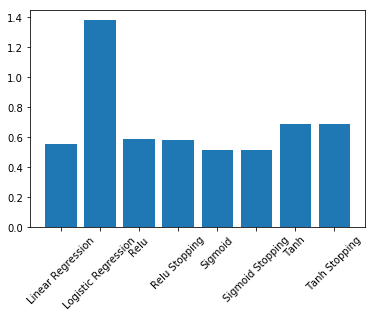

In [57]:
# plotting RMSE score for all regression models

score_list_reg=[score_lin_classic,score_log_classic,score_reg_relu,score_reg_relu_stopping,score_reg_sig,score_reg_sig_stopping,score_reg_tanh,score_reg_tanh_stopping]
names =['Linear Regression','Logistic Regression','Relu','Relu Stopping','Sigmoid','Sigmoid Stopping','Tanh','Tanh Stopping']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg)), score_list_reg)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# Relu with Postal Code and Categories

In [58]:
# one-hot cooding of postal codes 

postal_hotcoded_df = pd.get_dummies(merge_df['postal code'], sparse = 'true')

x_matrix_postal = np.column_stack((x_matrix_minmax, postal_hotcoded_df))
x_matrix_final = np.column_stack((x_matrix_postal, category_matrix))



In [59]:
print(y_stars_regression.shape)


(10000,)


In [60]:
#train test data
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_matrix_final, y_stars_regression , test_size=0.2)

In [61]:
# set up checkpointer
checkpointer_relu_postal = ModelCheckpoint(filepath="./best_weights_relu_postal.hdf5", verbose=2, save_best_only=True)

In [62]:
#Tensorflow model for regression
model_reg_relu = Sequential()

model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(1)) # Output

In [63]:
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_postal],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_postal.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 2.2098 - val_loss: 0.5011

Epoch 00001: val_loss improved from inf to 0.50115, saving model to ./best_weights_relu_postal.hdf5
Epoch 2/100
 - 1s - loss: 0.3419 - val_loss: 0.4082

Epoch 00002: val_loss improved from 0.50115 to 0.40819, saving model to ./best_weights_relu_postal.hdf5
Epoch 3/100
 - 1s - loss: 0.2196 - val_loss: 0.3995

Epoch 00003: val_loss improved from 0.40819 to 0.39951, saving model to ./best_weights_relu_postal.hdf5
Epoch 4/100
 - 1s - loss: 0.1702 - val_loss: 0.3856

Epoch 00004: val_loss improved from 0.39951 to 0.38562, saving model to ./best_weights_relu_postal.hdf5
Epoch 5/100
 - 1s - loss: 0.1372 - val_loss: 0.3893

Epoch 00005: val_loss did not improve from 0.38562
Epoch 6/100
 - 1s - loss: 0.1134 - val_loss: 0.4001

Epoch 00006: val_loss did not improve from 0.38562
Epoch 7/100
 - 1s - loss: 0.0931 - val_loss: 0.4023

Epoch 00007: val_loss did not improve from 0.38562
Epoch 00007: ear

Epoch 5/100
 - 1s - loss: 0.0051 - val_loss: 0.3619

Epoch 00005: val_loss did not improve from 0.35923
Epoch 6/100
 - 1s - loss: 0.0048 - val_loss: 0.3579

Epoch 00006: val_loss improved from 0.35923 to 0.35795, saving model to ./best_weights_relu_postal.hdf5
Epoch 7/100
 - 1s - loss: 0.0045 - val_loss: 0.3601

Epoch 00007: val_loss did not improve from 0.35795
Epoch 8/100
 - 1s - loss: 0.0045 - val_loss: 0.3563

Epoch 00008: val_loss improved from 0.35795 to 0.35626, saving model to ./best_weights_relu_postal.hdf5
Epoch 9/100
 - 1s - loss: 0.0048 - val_loss: 0.3605

Epoch 00009: val_loss did not improve from 0.35626
Epoch 10/100
 - 1s - loss: 0.0047 - val_loss: 0.3603

Epoch 00010: val_loss did not improve from 0.35626
Epoch 11/100
 - 1s - loss: 0.0044 - val_loss: 0.3604

Epoch 00011: val_loss did not improve from 0.35626
Epoch 00011: early stopping


In [64]:
# Predict stars
pred_reg_stopping = model_reg_relu.predict(x_test_reg)
print("Shape: {}".format(pred_reg_stopping.shape))

Shape: (2000, 1)


In [65]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [4.0271177]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.6701283]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.4788647]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.633781]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.2558086]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.9144561]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.488705]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.6495156]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [4.9873514]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.0438144]


In [66]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_postal = np.sqrt(mean_squared_error(y_test_reg,pred_reg_stopping))
print("Final score (RMSE): {}".format(score_relu_postal))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_stopping))

Final score (RMSE): 0.5968785881996155
R2 score: 0.67


# Experimenting with different optimizers for ReLU

In [67]:
# set up checkpointer
checkpointer_relu_sgd = ModelCheckpoint(filepath="./best_weights_relu_sgd.hdf5", verbose=2, save_best_only=True)

In [68]:
#Model training with Stochastic gradient descent optimizer(SGD).
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='sgd')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_sgd],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_sgd.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 2s - loss: 0.0040 - val_loss: 0.3564

Epoch 00001: val_loss improved from inf to 0.35644, saving model to ./best_weights_relu_sgd.hdf5
Epoch 2/100
 - 1s - loss: 0.0037 - val_loss: 0.3566

Epoch 00002: val_loss did not improve from 0.35644
Epoch 3/100
 - 1s - loss: 0.0036 - val_loss: 0.3566

Epoch 00003: val_loss did not improve from 0.35644
Epoch 4/100
 - 1s - loss: 0.0034 - val_loss: 0.3564

Epoch 00004: val_loss improved from 0.35644 to 0.35638, saving model to ./best_weights_relu_sgd.hdf5
Epoch 00004: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 2s - loss: 0.0033 - val_loss: 0.3566

Epoch 00001: val_loss did not improve from 0.35638
Epoch 2/100
 - 1s - loss: 0.0032 - val_loss: 0.3564

Epoch 00002: val_loss improved from 0.35638 to 0.35635, saving model to ./best_weights_relu_sgd.hdf5
Epoch 3/100
 - 1s - loss: 0.0032 - val_loss: 0.3566

Epoch 00003: val_loss did not improve from 0.35635
Ep

In [69]:
# Predict stars
pred_reg_sgd = model_reg_relu.predict(x_test_reg)

In [70]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_sgd[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [4.0224066]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.6558514]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.3980303]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.6580343]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.2512727]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.8860996]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.5032425]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.6358366]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [4.955144]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.0325363]


In [71]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_sgd = np.sqrt(mean_squared_error(y_test_reg,pred_reg_sgd))
print("Final score (RMSE): {}".format(score_relu_sgd))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_sgd))

Final score (RMSE): 0.5965737104415894
R2 score: 0.67


In [72]:
# set up checkpointer
checkpointer_relu_rmsprop = ModelCheckpoint(filepath="./best_weights_relu_rmsprop.hdf5", verbose=2, save_best_only=True)

In [73]:
#Model training with RMSProp optimizer.
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='rmsprop')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_rmsprop],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_rmsprop.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 0.0068 - val_loss: 0.3563

Epoch 00001: val_loss improved from inf to 0.35634, saving model to ./best_weights_relu_rmsprop.hdf5
Epoch 2/100
 - 1s - loss: 0.0062 - val_loss: 0.3570

Epoch 00002: val_loss did not improve from 0.35634
Epoch 3/100
 - 1s - loss: 0.0058 - val_loss: 0.3704

Epoch 00003: val_loss did not improve from 0.35634
Epoch 4/100
 - 1s - loss: 0.0056 - val_loss: 0.3597

Epoch 00004: val_loss did not improve from 0.35634
Epoch 00004: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 0.0057 - val_loss: 0.3615

Epoch 00001: val_loss did not improve from 0.35634
Epoch 2/100
 - 1s - loss: 0.0055 - val_loss: 0.3666

Epoch 00002: val_loss did not improve from 0.35634
Epoch 3/100
 - 1s - loss: 0.0052 - val_loss: 0.3606

Epoch 00003: val_loss did not improve from 0.35634
Epoch 4/100
 - 1s - loss: 0.0051 - val_loss: 0.3678

Epoch 00004: val_loss did not improve from 0.

In [74]:
# Predict stars
pred_reg_rmsprop = model_reg_relu.predict(x_test_reg)

In [75]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_rmsprop[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [4.0967507]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.6052527]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.3680725]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.6078935]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.254089]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.872034]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.4700384]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.5457177]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [5.049957]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.054903]


In [76]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_rmsprop = np.sqrt(mean_squared_error(y_test_reg,pred_reg_rmsprop))
print("Final score (RMSE): {}".format(score_relu_rmsprop))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_rmsprop))

Final score (RMSE): 0.5948983430862427
R2 score: 0.67


In [77]:
# set up checkpointer
checkpointer_relu_adagrad = ModelCheckpoint(filepath="./best_weights_relu_adagrad.hdf5", verbose=2, save_best_only=True)

In [78]:
#Model training with Adagrad.
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adagrad')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_adagrad],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_adagrad.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 0.0055 - val_loss: 0.3569

Epoch 00001: val_loss improved from inf to 0.35693, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 2/100
 - 1s - loss: 0.0025 - val_loss: 0.3534

Epoch 00002: val_loss improved from 0.35693 to 0.35339, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 3/100
 - 1s - loss: 6.9534e-04 - val_loss: 0.3553

Epoch 00003: val_loss did not improve from 0.35339
Epoch 4/100
 - 1s - loss: 2.7535e-04 - val_loss: 0.3551

Epoch 00004: val_loss did not improve from 0.35339
Epoch 5/100
 - 1s - loss: 1.3673e-04 - val_loss: 0.3557

Epoch 00005: val_loss did not improve from 0.35339
Epoch 00005: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 0.0044 - val_loss: 0.3568

Epoch 00001: val_loss did not improve from 0.35339
Epoch 2/100
 - 1s - loss: 0.0028 - val_loss: 0.3543

Epoch 00002: val_loss did not improve from 0.35339
Epoch 3/100
 - 1s - loss: 7.3743

In [79]:
# Predict stars
pred_reg_adagrad = model_reg_relu.predict(x_test_reg)

In [80]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_adagrad[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [4.0515122]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.673735]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.376206]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.5739026]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.2332797]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.8514984]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.4683263]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.568422]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [5.029643]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.089767]


In [81]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_adagrad = np.sqrt(mean_squared_error(y_test_reg,pred_reg_adagrad))
print("Final score (RMSE): {}".format(score_relu_adagrad))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_adagrad))

Final score (RMSE): 0.594461977481842
R2 score: 0.67


In [82]:
# set up checkpointer
checkpointer_relu_adadelta = ModelCheckpoint(filepath="./best_weights_relu_adadelta.hdf5", verbose=2, save_best_only=True)

In [83]:
#Model training with ADadelta.
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adadelta')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_adadelta],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_adadelta.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 0.0025 - val_loss: 0.3594

Epoch 00001: val_loss improved from inf to 0.35942, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 2/100
 - 1s - loss: 0.0035 - val_loss: 0.3581

Epoch 00002: val_loss improved from 0.35942 to 0.35807, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 3/100
 - 1s - loss: 0.0026 - val_loss: 0.3558

Epoch 00003: val_loss improved from 0.35807 to 0.35578, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 4/100
 - 1s - loss: 0.0023 - val_loss: 0.3560

Epoch 00004: val_loss did not improve from 0.35578
Epoch 5/100
 - 1s - loss: 0.0023 - val_loss: 0.3571

Epoch 00005: val_loss did not improve from 0.35578
Epoch 6/100
 - 1s - loss: 0.0033 - val_loss: 0.3570

Epoch 00006: val_loss did not improve from 0.35578
Epoch 00006: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 0.0020 - val_loss: 0.3581

Epoch 00001: val_loss did not improve 

In [84]:
# Predict stars
pred_reg_adadelta = model_reg_relu.predict(x_test_reg)

In [85]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_adadelta[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [4.0375576]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.6432195]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.420752]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.5686216]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.2340143]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.8594866]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.4584217]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.526681]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [4.9973984]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.0598068]


In [86]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_adadelta = np.sqrt(mean_squared_error(y_test_reg,pred_reg_adadelta))
print("Final score (RMSE): {}".format(score_relu_adadelta))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_adadelta))

Final score (RMSE): 0.5961122512817383
R2 score: 0.67


In [87]:
# set up checkpointer
checkpointer_relu_adamax = ModelCheckpoint(filepath="./best_weights_relu_adamax.hdf5",verbose=2, save_best_only=True)

In [88]:
#Model training with Stochastic gradient descent optimizer(SGD).
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adamax')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_adamax],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_adamax.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 6.3042e-04 - val_loss: 0.3568

Epoch 00001: val_loss improved from inf to 0.35680, saving model to ./best_weights_relu_adamax.hdf5
Epoch 2/100
 - 1s - loss: 3.6580e-04 - val_loss: 0.3562

Epoch 00002: val_loss improved from 0.35680 to 0.35620, saving model to ./best_weights_relu_adamax.hdf5
Epoch 3/100
 - 1s - loss: 2.3040e-04 - val_loss: 0.3557

Epoch 00003: val_loss improved from 0.35620 to 0.35571, saving model to ./best_weights_relu_adamax.hdf5
Epoch 4/100
 - 1s - loss: 1.9983e-04 - val_loss: 0.3560

Epoch 00004: val_loss did not improve from 0.35571
Epoch 5/100
 - 1s - loss: 2.3064e-04 - val_loss: 0.3552

Epoch 00005: val_loss improved from 0.35571 to 0.35524, saving model to ./best_weights_relu_adamax.hdf5
Epoch 6/100
 - 1s - loss: 2.6202e-04 - val_loss: 0.3565

Epoch 00006: val_loss did not improve from 0.35524
Epoch 00006: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - 

In [89]:
# Predict stars
pred_reg_adamax = model_reg_relu.predict(x_test_reg)

In [90]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_adamax[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [4.1020093]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.6861453]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.4172535]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.629422]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.2480528]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.8422844]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.4617307]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.563878]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [5.0696855]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.0938659]


In [91]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_adamax = np.sqrt(mean_squared_error(y_test_reg,pred_reg_adamax))
print("Final score (RMSE): {}".format(score_relu_adamax))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_adamax))

Final score (RMSE): 0.5955179333686829
R2 score: 0.67


In [92]:
# set up checkpointer
checkpointer_relu_nadam = ModelCheckpoint(filepath="./best_weights_relu_nadam.hdf5", verbose=2, save_best_only=True)

In [93]:
#Model training with Stochastic gradient descent optimizer(SGD).
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='nadam')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_nadam],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_nadam.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 4s - loss: 0.0067 - val_loss: 0.3663

Epoch 00001: val_loss improved from inf to 0.36634, saving model to ./best_weights_relu_nadam.hdf5
Epoch 2/100
 - 2s - loss: 0.0231 - val_loss: 0.3696

Epoch 00002: val_loss did not improve from 0.36634
Epoch 3/100
 - 2s - loss: 0.0179 - val_loss: 0.3530

Epoch 00003: val_loss improved from 0.36634 to 0.35299, saving model to ./best_weights_relu_nadam.hdf5
Epoch 4/100
 - 2s - loss: 0.0113 - val_loss: 0.3528

Epoch 00004: val_loss improved from 0.35299 to 0.35276, saving model to ./best_weights_relu_nadam.hdf5
Epoch 5/100
 - 2s - loss: 0.0083 - val_loss: 0.3549

Epoch 00005: val_loss did not improve from 0.35276
Epoch 6/100
 - 2s - loss: 0.0079 - val_loss: 0.3525

Epoch 00006: val_loss improved from 0.35276 to 0.35245, saving model to ./best_weights_relu_nadam.hdf5
Epoch 00006: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 4s - loss: 0.0100 - val_loss: 0.3

In [94]:
# Predict stars
pred_reg_nadam = model_reg_relu.predict(x_test_reg)

In [95]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_nadam[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [3.88986]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.6396694]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.2682767]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.645605]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.3555214]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.8175664]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.446373]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.7038507]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [4.9353976]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.0834134]


In [96]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_nadam = np.sqrt(mean_squared_error(y_test_reg,pred_reg_nadam))
print("Final score (RMSE): {}".format(score_relu_nadam))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_nadam))

Final score (RMSE): 0.5785612463951111
R2 score: 0.69


In [ ]:
# plotting RMSE score for different Optimizers for relu model

score_list_optimizer=[score_reg_relu_stopping,score_relu_sgd,score_relu_rmsprop,score_relu_adagrad,score_relu_adadelta,score_relu_adamax,score_relu_nadam]
names =['adam','SGD','RMSprop','Adagrad','Adadelta','Adamax','Nadam']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_optimizer)), score_list_optimizer)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# Experiments with Hidden nodes selection in hidden layer 

In [98]:
# set up checkpointer
checkpointer_relu_2l = ModelCheckpoint(filepath="./best_weights_relu_2l.hdf5", verbose=2, save_best_only=True)

In [99]:
# Tensorflow model for Regression with sigmoid and forward approach
model_reg_relu = Sequential()

model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu'))  
model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(1)) # Output


In [100]:
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_2l],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_2l.hdf5')


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 4s - loss: 2.2041 - val_loss: 0.4717

Epoch 00001: val_loss improved from inf to 0.47170, saving model to ./best_weights_relu_2l.hdf5
Epoch 2/100
 - 2s - loss: 0.3230 - val_loss: 0.3951

Epoch 00002: val_loss improved from 0.47170 to 0.39510, saving model to ./best_weights_relu_2l.hdf5
Epoch 3/100
 - 2s - loss: 0.2180 - val_loss: 0.3842

Epoch 00003: val_loss improved from 0.39510 to 0.38424, saving model to ./best_weights_relu_2l.hdf5
Epoch 4/100
 - 2s - loss: 0.1733 - val_loss: 0.3834

Epoch 00004: val_loss improved from 0.38424 to 0.38335, saving model to ./best_weights_relu_2l.hdf5
Epoch 5/100
 - 2s - loss: 0.1474 - val_loss: 0.3917

Epoch 00005: val_loss did not improve from 0.38335
Epoch 6/100
 - 2s - loss: 0.1307 - val_loss: 0.3999

Epoch 00006: val_loss did not improve from 0.38335
Epoch 00006: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 4s - loss: 0.1289 - val_loss: 0.3976

Epoch 0

 - 2s - loss: 0.0052 - val_loss: 0.3496

Epoch 00003: val_loss did not improve from 0.34896
Epoch 4/100
 - 2s - loss: 0.0055 - val_loss: 0.3477

Epoch 00004: val_loss improved from 0.34896 to 0.34771, saving model to ./best_weights_relu_2l.hdf5
Epoch 5/100
 - 2s - loss: 0.0056 - val_loss: 0.3478

Epoch 00005: val_loss did not improve from 0.34771
Epoch 6/100
 - 2s - loss: 0.0056 - val_loss: 0.3514

Epoch 00006: val_loss did not improve from 0.34771
Epoch 7/100
 - 2s - loss: 0.0052 - val_loss: 0.3473

Epoch 00007: val_loss improved from 0.34771 to 0.34734, saving model to ./best_weights_relu_2l.hdf5
Epoch 00007: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 4s - loss: 0.0049 - val_loss: 0.3469

Epoch 00001: val_loss improved from 0.34734 to 0.34686, saving model to ./best_weights_relu_2l.hdf5
Epoch 2/100
 - 2s - loss: 0.0044 - val_loss: 0.3475

Epoch 00002: val_loss did not improve from 0.34686
Epoch 3/100
 - 2s - loss: 0.0046 - val_loss: 0.3446

Epoch 00

In [101]:
# Predict stars
pred_reg_hl = model_reg_relu.predict(x_test_reg)

In [102]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [3.9236302]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.3126464]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.5015845]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.907193]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.232567]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [4.096953]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.5040715]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.789931]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [4.587507]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.1313505]


In [103]:
# Measure RMSE error.  RMSE is common for regression.
score_2l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl))
print("Final score (RMSE): {}".format(score_2l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl))

Final score (RMSE): 0.5870042443275452
R2 score: 0.68


In [104]:
# set up checkpointer
checkpointer_relu_3l = ModelCheckpoint(filepath="./best_weights_relu_3l.hdf5", verbose=2, save_best_only=True)

In [105]:
# Tensorflow model for Regression with relu and forward approach with 3 hidden layers
model_reg_relu = Sequential()

model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu'))  
model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(10, activation='relu')) # Hidden 3
model_reg_relu.add(Dense(1)) # Output


In [106]:
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_3l],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_3l.hdf5')


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 4s - loss: 2.4100 - val_loss: 0.4742

Epoch 00001: val_loss improved from inf to 0.47422, saving model to ./best_weights_relu_3l.hdf5
Epoch 2/100
 - 2s - loss: 0.3261 - val_loss: 0.3868

Epoch 00002: val_loss improved from 0.47422 to 0.38682, saving model to ./best_weights_relu_3l.hdf5
Epoch 3/100
 - 2s - loss: 0.2102 - val_loss: 0.3775

Epoch 00003: val_loss improved from 0.38682 to 0.37753, saving model to ./best_weights_relu_3l.hdf5
Epoch 4/100
 - 2s - loss: 0.1610 - val_loss: 0.3803

Epoch 00004: val_loss did not improve from 0.37753
Epoch 5/100
 - 2s - loss: 0.1255 - val_loss: 0.3798

Epoch 00005: val_loss did not improve from 0.37753
Epoch 6/100
 - 2s - loss: 0.0991 - val_loss: 0.3914

Epoch 00006: val_loss did not improve from 0.37753
Epoch 00006: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 4s - loss: 0.0865 - val_loss: 0.3938

Epoch 00001: val_loss did not improve from 0.37753
Epoch

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 5s - loss: 0.0052 - val_loss: 0.3493

Epoch 00001: val_loss did not improve from 0.34767
Epoch 2/100
 - 2s - loss: 0.0043 - val_loss: 0.3466

Epoch 00002: val_loss improved from 0.34767 to 0.34662, saving model to ./best_weights_relu_3l.hdf5
Epoch 3/100
 - 2s - loss: 0.0043 - val_loss: 0.3453

Epoch 00003: val_loss improved from 0.34662 to 0.34526, saving model to ./best_weights_relu_3l.hdf5
Epoch 4/100
 - 2s - loss: 0.0047 - val_loss: 0.3451

Epoch 00004: val_loss improved from 0.34526 to 0.34511, saving model to ./best_weights_relu_3l.hdf5
Epoch 5/100
 - 2s - loss: 0.0048 - val_loss: 0.3470

Epoch 00005: val_loss did not improve from 0.34511
Epoch 6/100
 - 2s - loss: 0.0046 - val_loss: 0.3449

Epoch 00006: val_loss improved from 0.34511 to 0.34490, saving model to ./best_weights_relu_3l.hdf5
Epoch 00006: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 5s - loss: 0.0044 - val_loss: 0.3481

Epo

In [107]:
# Predict stars
pred_reg_hl_3 = model_reg_relu.predict(x_test_reg)

In [108]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl_3[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [3.7569768]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [3.7612178]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.3311234]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.388369]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.1347184]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.725758]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.4403157]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.2882605]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [4.796396]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.1163046]


In [109]:
# Measure RMSE error.  RMSE is common for regression.
score_3l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl_3))
print("Final score (RMSE): {}".format(score_3l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl_3))

Final score (RMSE): 0.5860057473182678
R2 score: 0.68


In [110]:
# set up checkpointer
checkpointer_relu_4l = ModelCheckpoint(filepath="./best_weights_relu_4l.hdf5", verbose=2, save_best_only=True)

In [111]:
# Tensorflow model for Regression with sigmoid and forward approach with 4 hidden layers
model_reg_relu = Sequential()

model_reg_relu.add(Dense(80, input_dim=x_train_reg.shape[1], activation='relu'))  
model_reg_relu.add(Dense(60, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(20, activation='relu')) # Hidden 3
model_reg_relu.add(Dense(10, activation='relu')) # Hidden 4
model_reg_relu.add(Dense(1)) # Output


In [112]:
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_4l],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_4l.hdf5')


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 5s - loss: 1.7569 - val_loss: 0.4450

Epoch 00001: val_loss improved from inf to 0.44499, saving model to ./best_weights_relu_4l.hdf5
Epoch 2/100
 - 2s - loss: 0.2967 - val_loss: 0.3966

Epoch 00002: val_loss improved from 0.44499 to 0.39661, saving model to ./best_weights_relu_4l.hdf5
Epoch 3/100
 - 2s - loss: 0.1988 - val_loss: 0.3840

Epoch 00003: val_loss improved from 0.39661 to 0.38403, saving model to ./best_weights_relu_4l.hdf5
Epoch 4/100
 - 2s - loss: 0.1512 - val_loss: 0.3790

Epoch 00004: val_loss improved from 0.38403 to 0.37897, saving model to ./best_weights_relu_4l.hdf5
Epoch 5/100
 - 2s - loss: 0.1196 - val_loss: 0.3841

Epoch 00005: val_loss did not improve from 0.37897
Epoch 6/100
 - 2s - loss: 0.0952 - val_loss: 0.3924

Epoch 00006: val_loss did not improve from 0.37897
Epoch 7/100
 - 2s - loss: 0.0712 - val_loss: 0.3832

Epoch 00007: val_loss did not improve from 0.37897
Epoch 00007: early stopping
Trai

 - 2s - loss: 0.0046 - val_loss: 0.3526

Epoch 00007: val_loss did not improve from 0.35052
Epoch 00007: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 6s - loss: 0.0047 - val_loss: 0.3503

Epoch 00001: val_loss improved from 0.35052 to 0.35025, saving model to ./best_weights_relu_4l.hdf5
Epoch 2/100
 - 2s - loss: 0.0041 - val_loss: 0.3489

Epoch 00002: val_loss improved from 0.35025 to 0.34892, saving model to ./best_weights_relu_4l.hdf5
Epoch 3/100
 - 2s - loss: 0.0047 - val_loss: 0.3503

Epoch 00003: val_loss did not improve from 0.34892
Epoch 4/100
 - 2s - loss: 0.0046 - val_loss: 0.3475

Epoch 00004: val_loss improved from 0.34892 to 0.34753, saving model to ./best_weights_relu_4l.hdf5
Epoch 5/100
 - 2s - loss: 0.0045 - val_loss: 0.3584

Epoch 00005: val_loss did not improve from 0.34753
Epoch 6/100
 - 2s - loss: 0.0047 - val_loss: 0.3473

Epoch 00006: val_loss improved from 0.34753 to 0.34725, saving model to ./best_weights_relu_4l.hdf5
Epoch 7/100


In [113]:
# Predict stars
pred_reg_hl_4 = model_reg_relu.predict(x_test_reg)

In [114]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl_4[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [3.6036444]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.3472104]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.337791]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.4997587]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.232984]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.5531738]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.5049272]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.572664]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [4.2858105]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.1794796]


In [115]:
# Measure RMSE error.  RMSE is common for regression.
score_4l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl_4))
print("Final score (RMSE): {}".format(score_4l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl_4))

Final score (RMSE): 0.5892806649208069
R2 score: 0.68


In [116]:
# set up checkpointer
checkpointer_relu_5l = ModelCheckpoint(filepath="./best_weights_relu_5l.hdf5", verbose=2, save_best_only=True)

In [117]:
# Tensorflow model for Regression with sigmoid and forward approach with 5 hidden layers
model_reg_relu = Sequential()

model_reg_relu.add(Dense(80, input_dim=x_train_reg.shape[1], activation='relu'))  
model_reg_relu.add(Dense(60, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(40, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(20, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(10, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(1)) # Output


In [118]:
for i in range(10):
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu_5l],verbose=2,epochs=100) 

model_reg_relu.load_weights('./best_weights_relu_5l.hdf5')


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 6s - loss: 2.1387 - val_loss: 0.4359

Epoch 00001: val_loss improved from inf to 0.43586, saving model to ./best_weights_relu_5l.hdf5
Epoch 2/100
 - 2s - loss: 0.2866 - val_loss: 0.3779

Epoch 00002: val_loss improved from 0.43586 to 0.37790, saving model to ./best_weights_relu_5l.hdf5
Epoch 3/100
 - 2s - loss: 0.1925 - val_loss: 0.3705

Epoch 00003: val_loss improved from 0.37790 to 0.37049, saving model to ./best_weights_relu_5l.hdf5
Epoch 4/100
 - 2s - loss: 0.1450 - val_loss: 0.3774

Epoch 00004: val_loss did not improve from 0.37049
Epoch 5/100
 - 2s - loss: 0.1101 - val_loss: 0.3802

Epoch 00005: val_loss did not improve from 0.37049
Epoch 6/100
 - 2s - loss: 0.0852 - val_loss: 0.3891

Epoch 00006: val_loss did not improve from 0.37049
Epoch 00006: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 6s - loss: 0.0798 - val_loss: 0.3892

Epoch 00001: val_loss did not improve from 0.37049
Epoch

 - 2s - loss: 0.0048 - val_loss: 0.3343

Epoch 00005: val_loss did not improve from 0.33129
Epoch 6/100
 - 2s - loss: 0.0043 - val_loss: 0.3376

Epoch 00006: val_loss did not improve from 0.33129
Epoch 7/100
 - 2s - loss: 0.0039 - val_loss: 0.3325

Epoch 00007: val_loss did not improve from 0.33129
Epoch 00007: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 6s - loss: 0.0040 - val_loss: 0.3319

Epoch 00001: val_loss did not improve from 0.33129
Epoch 2/100
 - 2s - loss: 0.0036 - val_loss: 0.3311

Epoch 00002: val_loss improved from 0.33129 to 0.33112, saving model to ./best_weights_relu_5l.hdf5
Epoch 3/100
 - 2s - loss: 0.0044 - val_loss: 0.3321

Epoch 00003: val_loss did not improve from 0.33112
Epoch 4/100
 - 2s - loss: 0.0047 - val_loss: 0.3359

Epoch 00004: val_loss did not improve from 0.33112
Epoch 00004: early stopping


In [119]:
# Predict stars
pred_reg_hl_5 = model_reg_relu.predict(x_test_reg)

In [120]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl_4[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [3.6036444]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.0, predicted Stars: [4.3472104]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.0, predicted Stars: [4.337791]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.5, predicted Stars: [4.4997587]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [3.232984]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.5531738]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [3.5049272]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.572664]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.5, predicted Stars: [4.2858105]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.1794796]


In [121]:
# Measure RMSE error.  RMSE is common for regression.
score_5l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl_5))
print("Final score (RMSE): {}".format(score_5l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl_5))

Final score (RMSE): 0.5754275918006897
R2 score: 0.69


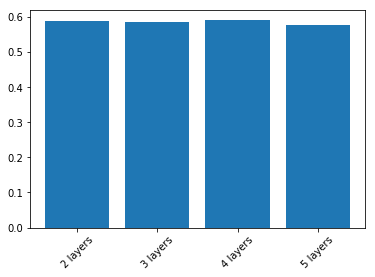

In [122]:
# plotting RMSE score for different number of layers for relu model

score_list_layers=[score_2l,score_3l,score_4l,score_5l]
names =['2 layers','3 layers','4 layers','5 layers']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_layers)), score_list_layers)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# TensorFlow Model for Classification

In [123]:
#train test data for linear regression

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, merge_df['encoded_stars'] , test_size=0.2, random_state=42)


In [124]:
#implementing Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(x_train_lr, y_train_lr) 

y_pred_knn = knn.predict(x_test_lr)

In [125]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test_lr.index[i]
    print("business id - %s actual stars label - %d predicted - %d" 
          %(merge_df['business_id'][idx], y_test_lr[idx], y_pred_knn[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars label - 6 predicted - 8
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars label - 6 predicted - 4
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars label - 6 predicted - 6
business id - jrhc4s5XMR8S8kpGdU08og actual stars label - 7 predicted - 6
business id - e7207sqC-pSn6GIf31ikhQ actual stars label - 6 predicted - 6
business id - CF9TxeEdP5QxihYFAl4sUg actual stars label - 6 predicted - 6
business id - zZPCAFK85NtitSNVP_wfYg actual stars label - 5 predicted - 7
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars label - 8 predicted - 7
business id - TTrYd662CZFRPaiwl-sUqA actual stars label - 2 predicted - 4
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars label - 3 predicted - 6


In [126]:
# Metrics

score_knn_acc = metrics.accuracy_score(y_test_lr, y_pred_knn)
print("Accuracy score: {}".format(score_knn_acc))

score_knn_precision = metrics.precision_score(y_test_lr, y_pred_knn, average= "weighted")
print("Precision score: {}".format(score_knn_precision))

score_knn_recall = metrics.recall_score(y_test_lr, y_pred_knn, average= "weighted")
print("Recall score: {}".format(score_knn_recall))

score_knn_f1 = metrics.f1_score(y_test_lr, y_pred_knn, average= "weighted")
print("F1 score: {}".format(score_knn_f1))



Accuracy score: 0.295
Precision score: 0.2960480875614052
Recall score: 0.295
F1 score: 0.2918900582503685


In [127]:
mnb_model = MultinomialNB()

mnb_model.fit(x_train_lr, y_train_lr)

y_pred_mnb = mnb_model.predict(x_test_lr)

In [128]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test_lr.index[i]
    print("business id - %s actual stars label - %d predicted - %d" 
          %(merge_df['business_id'][idx], y_test_lr[idx], y_pred_mnb[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars label - 6 predicted - 8
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars label - 6 predicted - 6
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars label - 6 predicted - 6
business id - jrhc4s5XMR8S8kpGdU08og actual stars label - 7 predicted - 7
business id - e7207sqC-pSn6GIf31ikhQ actual stars label - 6 predicted - 6
business id - CF9TxeEdP5QxihYFAl4sUg actual stars label - 6 predicted - 8
business id - zZPCAFK85NtitSNVP_wfYg actual stars label - 5 predicted - 8
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars label - 8 predicted - 8
business id - TTrYd662CZFRPaiwl-sUqA actual stars label - 2 predicted - 3
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars label - 3 predicted - 0


In [129]:
# Metrics

score_mnb_acc = metrics.accuracy_score(y_test_lr, y_pred_mnb)
print("Accuracy score: {}".format(score_mnb_acc))

score_mnb_precision = metrics.precision_score(y_test_lr, y_pred_mnb, average= "weighted")
print("Precision score: {}".format(score_mnb_precision))

score_mnb_recall = metrics.recall_score(y_test_lr, y_pred_mnb, average= "weighted")
print("Recall score: {}".format(score_mnb_recall))

score_mnb_f1 = metrics.f1_score(y_test_lr, y_pred_mnb, average= "weighted")
print("F1 score: {}".format(score_mnb_f1))

Accuracy score: 0.3325
Precision score: 0.29977451126707483
Recall score: 0.3325
F1 score: 0.2831433707336793


In [130]:
# one-hot cooding of postal codes 

hotcoded_stars_df = pd.get_dummies(merge_df['encoded_stars'], sparse = 'true')

In [131]:
y_stars_encoded = hotcoded_stars_df.values.astype(np.float32)

In [132]:
#train test data for 

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, y_stars_encoded, test_size=0.2, random_state=42)


In [133]:
#Tensorflow classification

model_class = Sequential()
model_class.add(Dense(50, input_dim=x_train_lr.shape[1], activation='relu')) # Hidden 1
model_class.add(Dense(25, activation='relu')) # Hidden 2
model_class.add(Dense(y_train_lr.shape[1], activation='softmax')) # Output

model_class.compile(loss='categorical_crossentropy', optimizer='adam')

model_class.fit(x_train_lr,y_train_lr,verbose=2,epochs=100)

Epoch 1/100
 - 4s - loss: 1.7835
Epoch 2/100
 - 1s - loss: 1.3468
Epoch 3/100
 - 1s - loss: 1.1881
Epoch 4/100
 - 1s - loss: 1.1043
Epoch 5/100
 - 1s - loss: 1.0541
Epoch 6/100
 - 1s - loss: 1.0025
Epoch 7/100
 - 1s - loss: 0.9625
Epoch 8/100
 - 1s - loss: 0.9229
Epoch 9/100
 - 1s - loss: 0.8861
Epoch 10/100
 - 1s - loss: 0.8479
Epoch 11/100
 - 1s - loss: 0.8162
Epoch 12/100
 - 1s - loss: 0.7821
Epoch 13/100
 - 1s - loss: 0.7457
Epoch 14/100
 - 1s - loss: 0.7148
Epoch 15/100
 - 1s - loss: 0.6881
Epoch 16/100
 - 1s - loss: 0.6525
Epoch 17/100
 - 1s - loss: 0.6201
Epoch 18/100
 - 1s - loss: 0.5911
Epoch 19/100
 - 1s - loss: 0.5632
Epoch 20/100
 - 1s - loss: 0.5292
Epoch 21/100
 - 1s - loss: 0.4980
Epoch 22/100
 - 1s - loss: 0.4710
Epoch 23/100
 - 1s - loss: 0.4426
Epoch 24/100
 - 1s - loss: 0.4150
Epoch 25/100
 - 1s - loss: 0.3874
Epoch 26/100
 - 1s - loss: 0.3640
Epoch 27/100
 - 1s - loss: 0.3371
Epoch 28/100
 - 1s - loss: 0.3153
Epoch 29/100
 - 1s - loss: 0.2926
Epoch 30/100
 - 1s - lo

In [134]:
pred_class = model_class.predict(x_test_lr)
print("Shape: {}".format(pred_class.shape))
print(pred_class)

Shape: (2000, 9)
[[0.0000000e+00 9.0550011e-32 1.3659213e-34 ... 9.9981183e-01
  1.0377554e-08 5.8346041e-18]
 [0.0000000e+00 6.4917041e-37 0.0000000e+00 ... 7.1663570e-01
  4.5088825e-08 1.3659771e-15]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.3362568e-07
  1.4631912e-02 9.8536795e-01]
 ...
 [1.4083814e-15 2.9510001e-02 1.7830956e-01 ... 3.6779843e-13
  1.8252636e-18 2.5144965e-23]
 [3.3521966e-10 2.0965272e-06 7.9351793e-07 ... 3.9346814e-05
  4.6281608e-07 2.1384891e-10]
 [0.0000000e+00 6.0629617e-29 2.2351458e-32 ... 6.8042896e-06
  7.2141000e-15 3.6652270e-23]]


In [135]:
predict_stars = np.argmax(pred_class,axis=1)

true_stars = np.argmax(y_test_lr,axis=1)

In [136]:
for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],true_stars[i],predict_stars[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 6, predicted Stars: 6
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 6, predicted Stars: 6
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 6, predicted Stars: 8
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 7, predicted Stars: 7
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 6, predicted Stars: 6
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 6, predicted Stars: 6
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 5, predicted Stars: 5
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 8, predicted Stars: 7
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 2, predicted Stars: 2
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 3, predicted Stars: 3


In [137]:
# Metrics

score_tf_acc = metrics.accuracy_score(true_stars, predict_stars)
print("Accuracy score: {}".format(score_tf_acc))

score_tf_precision = metrics.precision_score(true_stars, predict_stars, average= "weighted")
print("Precision score: {}".format(score_tf_precision))

score_tf_recall = metrics.recall_score(true_stars, predict_stars, average= "weighted")
print("Recall score: {}".format(score_tf_recall))

score_tf_f1 = metrics.f1_score(true_stars, predict_stars, average= "weighted")
print("F1 score: {}".format(score_tf_f1))

Accuracy score: 0.4235
Precision score: 0.42908601811601144
Recall score: 0.4235
F1 score: 0.4256234887594561


# Classification with Stopping

In [144]:
#Tensorflow classification with stopping

model_class = Sequential()
model_class.add(Dense(70, input_dim=x_train_lr.shape[1], activation='relu')) # Hidden 1
model_class.add(Dense(30, activation='relu')) # Hidden 2
model_class.add(Dense(y_train_lr.shape[1], activation='softmax')) # Output

In [145]:
# set up checkpointer
checkpointer_classification = ModelCheckpoint(filepath="./best_weights_classification.hdf5", verbose=2, save_best_only=True)

In [ ]:
for i in range(10):
    model_class.compile(loss='categorical_crossentropy', optimizer='adam')
    model_class.fit(x_train_lr,y_train_lr,validation_data=(x_test_lr,y_test_lr),callbacks=[monitor,checkpointer_classification],verbose=2,epochs=100) 

model_class.load_weights('./best_weights_classification.hdf5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 5s - loss: 1.7665 - val_loss: 1.4384

Epoch 00001: val_loss improved from inf to 1.43845, saving model to ./best_weights_classification.hdf5
Epoch 2/100
 - 1s - loss: 1.3082 - val_loss: 1.2876

Epoch 00002: val_loss improved from 1.43845 to 1.28761, saving model to ./best_weights_classification.hdf5
Epoch 3/100
 - 1s - loss: 1.1688 - val_loss: 1.2556

Epoch 00003: val_loss improved from 1.28761 to 1.25556, saving model to ./best_weights_classification.hdf5
Epoch 4/100
 - 1s - loss: 1.0884 - val_loss: 1.2558

Epoch 00004: val_loss did not improve from 1.25556
Epoch 5/100
 - 1s - loss: 1.0276 - val_loss: 1.2612

Epoch 00005: val_loss did not improve from 1.25556
Epoch 6/100
 - 1s - loss: 0.9716 - val_loss: 1.2772

Epoch 00006: val_loss did not improve from 1.25556
Epoch 00006: early stopping
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 5s - loss: 0.9137 - val_loss: 1.3044

Epoch 00001: val_loss did not impro

In [ ]:
pred_class_stopping = model_class.predict(x_test_lr)
print("Shape: {}".format(pred_class_stopping.shape))
print(pred_class_stopping)

In [ ]:
predict_stars = np.argmax(pred_class,axis=1)

true_stars = np.argmax(y_test_lr,axis=1)

In [ ]:
for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],true_stars[i],predict_stars[i]))

In [ ]:
# Metrics

score_tf_acc_stopping = metrics.accuracy_score(true_stars, predict_stars)
print("Accuracy score: {}".format(score_tf_acc_stopping))

score_tf_precision_stopping = metrics.precision_score(true_stars, predict_stars, average= "weighted")
print("Precision score: {}".format(score_tf_precision_stopping))

score_tf_recall_stopping = metrics.recall_score(true_stars, predict_stars, average= "weighted")
print("Recall score: {}".format(score_tf_recall_stopping))

score_tf_f1_stopping = metrics.f1_score(true_stars, predict_stars, average= "weighted")
print("F1 score: {}".format(score_tf_f1_stopping))

# Classification with postal and categories

In [ ]:
#train test data for linear regression

x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x_matrix_final, y_stars_encoded, test_size=0.2, random_state=42)


In [ ]:
#Tensorflow classification

model_class = Sequential()
model_class.add(Dense(50, input_dim=x_train_tf.shape[1], activation='relu')) # Hidden 1
model_class.add(Dense(25, activation='relu')) # Hidden 2
model_class.add(Dense(y_train_lr.shape[1], activation='softmax')) # Output

model_class.compile(loss='categorical_crossentropy', optimizer='adam')

model_class.fit(x_train_tf,y_train_tf,verbose=2,epochs=50)

In [ ]:
pred_class = model_class.predict(x_test_tf)
print("Shape: {}".format(pred_class.shape))
print(pred_class)

In [ ]:
predict_stars = np.argmax(pred_class,axis=1)

true_stars = np.argmax(y_test_tf,axis=1)

In [ ]:
for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],true_stars[i],predict_stars[i]))

In [ ]:
# Metrics

score_tf_acc_postal = metrics.accuracy_score(true_stars, predict_stars)
print("Accuracy score: {}".format(score_tf_acc_postal))

score_tf_precision_postal = metrics.precision_score(true_stars, predict_stars, average= "weighted")
print("Precision score: {}".format(score_tf_precision_postal))

score_tf_recall_postal = metrics.recall_score(true_stars, predict_stars, average= "weighted")
print("Recall score: {}".format(score_tf_recall_postal))

score_tf_f1_postal = metrics.f1_score(true_stars, predict_stars, average= "weighted")
print("F1 score: {}".format(score_tf_f1_postal))

In [ ]:
# plotting RMSE score for different number of layers for relu model

score_list_Classification=[score_knn_acc,score_mnb_acc,score_tf_acc,score_tf_acc_stopping,score_tf_acc_postal]
names =['KNN','MNB','TF Classification','TF Classification Stopping','TF postal + Categories']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_Classification)), score_list_Classification)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# Additional Features

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn import metrics
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.models import Sequential

In [ ]:
#train test data
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_matrix_minmax, y_stars_regression , test_size=0.2)

In [ ]:
#USe linear regression for regularization
model_regularization = Sequential()
model_regularization.add(Dense(50, input_dim=x_train_reg.shape[1], activation='relu'))
model_regularization.add(Dense(25, activation='relu'))
model_regularization.add(Dense(10, 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01), activation='relu'))
model_regularization.add(Dense(1)) 
model_regularization.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

model_regularization.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor],verbose=2,epochs=100)

pred_regularization = model_regularization.predict(x_test_reg)

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_regularization = np.sqrt(metrics.mean_squared_error(pred_regularization,y_test_reg))
print("Final score (RMSE): {}".format(score_regularization))

In [ ]:
# Dropout

model_dropout = Sequential()
model_dropout.add(Dense(50, input_dim=x_train_reg.shape[1]))
model_dropout.add(Dropout(0.1))

model_dropout.add(Dense(25, activation='relu'))
model_dropout.add(Dense(10, activation='relu'))
model_dropout.add(Dense(1))

model_dropout.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model_dropout.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor],verbose=0,epochs=1000)

pred_dropout = model_dropout.predict(x_test_reg)

# Measure RMSE error.  RMSE is common for regression.
score_dropout = np.sqrt(metrics.mean_squared_error(pred_dropout,y_test_reg))
print("Final score (RMSE): {}".format(score_dropout))

In [ ]:
model_dropout.summary()

In [ ]:
#Checking to see if regularization helps with over fitting when using postal code and categories and one hot coded values
#train test data
x_train_reg_ad, x_test_reg_ad, y_train_reg_ad, y_test_reg_ad = train_test_split(x_matrix_final, y_stars_regression , test_size=0.2)


In [ ]:
#USe linear regression for regularization
model_regularization_ad = Sequential()
model_regularization_ad.add(Dense(50, input_dim=x_train_reg_ad.shape[1], activation='relu'))
model_regularization_ad.add(Dense(25, activation='relu'))
model_regularization_ad.add(Dense(10, 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01), activation='relu'))
model_regularization_ad.add(Dense(1)) 
model_regularization_ad.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model_regularization_ad.fit(x_train_reg_ad,y_train_reg_ad,validation_data=(x_test_reg_ad,y_test_reg_ad),callbacks=[monitor],verbose=2,epochs=100)

pred_regularization_ad = model_regularization_ad.predict(x_test_reg_ad)

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_regularization_ad = np.sqrt(metrics.mean_squared_error(pred_regularization_ad,y_test_reg_ad))
print("Final score (RMSE): {}".format(score_regularization_ad))

In [ ]:
# Dropout

model_dropout_ad = Sequential()
model_dropout_ad.add(Dense(50, input_dim=x_train_reg_ad.shape[1]))
model_dropout_ad.add(Dropout(0.1))

model_dropout_ad.add(Dense(25, activation='relu'))
model_dropout_ad.add(Dense(10, activation='relu'))
model_dropout_ad.add(Dense(1))

model_dropout_ad.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model_dropout_ad.fit(x_train_reg_ad,y_train_reg_ad,validation_data=(x_test_reg_ad,y_test_reg_ad),callbacks=[monitor],verbose=2,epochs=1000)

pred_dropout_ad = model_dropout_ad.predict(x_test_reg_ad)

# Measure RMSE error.  RMSE is common for regression.
score_dropout_ad = np.sqrt(metrics.mean_squared_error(pred_dropout_ad,y_test_reg_ad))
print("Final score (RMSE): {}".format(score_dropout_ad))

In [ ]:
model_dropout_ad.summary()

# SVM

In [131]:
# SVM

svm_model = SVC(kernel="linear")

svm_model.fit(x_train_lr, y_train_lr)

y_pred_svm = svm_model.predict(x_test_lr)

In [132]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test_lr.index[i]
    print("business id - %s actual stars label - %d predicted - %d" 
          %(merge_df['business_id'][idx], y_test_lr[idx], y_pred_svm[i]))

business id - EmezZdxbvjydG5FkN6Mecw actual stars label - 2 predicted - 6
business id - cmaPrML-0zCJOs8_1VYmaw actual stars label - 7 predicted - 6
business id - E6U8zl527AsspbTf5nZCdw actual stars label - 4 predicted - 6
business id - zXRf_6Bs1yX9an_QKpzbHQ actual stars label - 2 predicted - 6
business id - vllzSssD2HXGlzGUcITxhw actual stars label - 6 predicted - 6
business id - AcGRSWCpb7YB95MTsHlGEw actual stars label - 2 predicted - 6
business id - zfEcOCrgUKe8xYOdqNVmmA actual stars label - 5 predicted - 6
business id - z-q6Wu-L-iDCftYVfoElPw actual stars label - 8 predicted - 6
business id - K7c5wAhxd6CqtmBmY47c7g actual stars label - 5 predicted - 6
business id - b30HREePgMGPZMPaExTZSA actual stars label - 6 predicted - 6


In [133]:
# Metrics

score_svm_acc = metrics.accuracy_score(y_test_lr, y_pred_svm)
print("Accuracy score: {}".format(score_svm_acc))

score_svm_precision = metrics.precision_score(y_test_lr, y_pred_svm, average= "weighted")
print("Precision score: {}".format(score_svm_precision))

score_svm_recall = metrics.recall_score(y_test_lr, y_pred_svm, average= "weighted")
print("Recall score: {}".format(score_svm_recall))

score_svm_f1 = metrics.f1_score(y_test_lr, y_pred_svm, average= "weighted")
print("F1 score: {}".format(score_svm_f1))



Final score (RMSE): 2.14247062073706
R2 score: -0.16
